# Линейная регрессия
__Суммарное количество баллов: 10__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.square(y_true - y_predicted).mean()

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    ss_t = ((y_true - np.mean(y_true, axis=0))**2).sum(axis=0)
    ss_r = ((y_true - y_predicted)**2).sum(axis=0)
    return (1 - (ss_r/ss_t))

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class NormalLR:
    def __init__(self):
        self.weights = None # Save weights here
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        X_train = np.hstack((X, np.ones((X.shape[0], 1))))
        self.weights = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        X_test = np.hstack((X, np.ones((X.shape[0], 1))))
        y_pred = X_test @ self.weights
        return y_pred

In [6]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.00964507827404138, R2: 0.998825839668841


### Задание 3 (4 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.weights = None # Save weights here
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.m = None
        self.n = None
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        X = np.insert(X, 0, 1, axis=1)
        y = y.reshape(y.shape[0], 1)
        self.m = X.shape[0]
        self.n = X.shape[1]
        self.weights = np.zeros((self.n , 1))
        for _ in range(self.iterations):
            preds = np.dot(X, self.weights)
            W_grad = (1 / self.m) * np.dot(X.T, (preds - y)) + self.l * np.sign(self.weights)
            self.weights -=  self.alpha * W_grad   

    def predict(self, X:np.ndarray):
        X = np.insert(X, 0, 1, axis=1)
        y_pred = np.dot(X, self.weights)
        return  y_pred.reshape(y_pred.shape[0])

In [9]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.02, 0.0002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [10]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

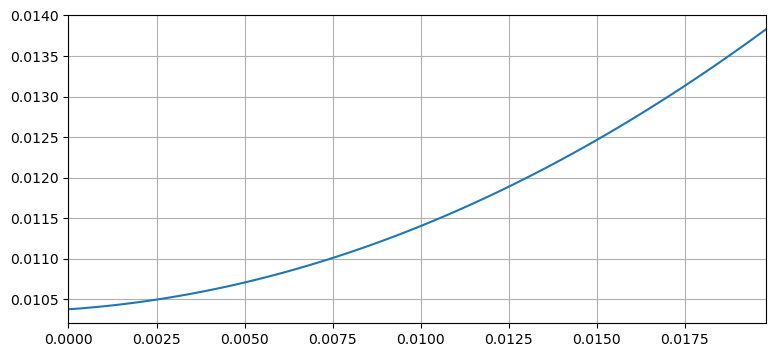

In [11]:
build_plot(X_train, y_train, X_val, y_val)

In [12]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009105441498203836, R2: 0.9959542313210586


### Задание 4 (2 балла)
Линейная регрессия является методом, который можно интерпретировать основываясь на значениях весов модели. Реализуйте метод, который будет упорядочивать признаки по их важности от наибольшей важности к наименьшей.

Обратите внимание, что такая интерпретация имеет смысл только если данные предварительно нормализованы, а также в признаках нет мультиколлинеарности (если используете обычную линейную регрессию).

#### Методы
`get_feature_importance` - метод, который вычисляет важность для каждого признака. Принимает на вход обученную линейную регрессию, возвращает список значений метрики важности признаков.

`get_most_important_features`- метод, который упорядочевает признаки по их важности в порядке убывания. Принимает на вход обученную линейную регрессию, возвращает упорядоченный список, состоящий из индексов признаков.

In [13]:
def get_feature_importance(linear_regression):
    return [abs(i) for i in linear_regression.weights.reshape(linear_regression.weights.shape[0])][1:]

def get_most_important_features(linear_regression):
    freatures_imp = get_feature_importance(linear_regression)
    return [x for x, y in sorted(enumerate(freatures_imp), key = lambda x: -x[1])]

In [14]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print(get_feature_importance(regr))
print(get_most_important_features(regr))

[0.6991777206013767, 0.5670310633670048, 0.19940431224195115, 1.0305181797275758, 0.3191999762880475, 1.8264840436910696]
[5, 3, 0, 1, 4, 2]


In [15]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print(get_feature_importance(regr))
print(get_most_important_features(regr))

[0.23444483544561506, 0.6991777206013762, 0.5670310633670044, 0.19940431224195132, 1.030518179727575, 0.31919997628804714]
[4, 1, 2, 5, 0, 3]
